In [1]:
import numpy as np
import lmadatagen as ldg
print(ldg)

<module 'lmadatagen' from '/Users/SophusOlsen/Desktop/lmadatagen/lmadatagen/__init__.py'>


In [2]:
'''
    Fetch the raw video chunks stored as .json files 
    from the disc. We can use cached data if they files
    have been previously loaded.
'''

ret_from_disc = False
path_to_json = './json/partial/'

json_util = ldg.LMAJSONUtil(ldg.joint_keys, ldg.joint_indeces, ldg.meta_keys)

# Load the video chunks as a list.
segments = json_util.get_video_segments(
    path_to_json,
    not ret_from_disc,
    ret_from_disc
)

[*]  Processed 191 files

In [3]:
'''
    Compute and extract motion features (based on LMA) from the motion
    data acquired through openpose. Various hyperparameters can be setup
    before extraction.
    
    We can setup hyperparameters for each available feature. The features are:
    [0] weight
    [1] time
    [2] space
    [3] flow
    [4] shape
    
    The hyperparameter is a LIST containig a 3D-tuple with the following meanings:
    
    TUPLE = (feature, effector, weights)
    LIST = [TUPLE0 ... TUPLE4]
    
    The LIST does not need to contain exactly 5 values, but it cannot exceed this limit.
    An effector is joint that is included in the computation of the feature. 
    The weights are a list of values (any numbers) corresponding to how important the
    correspoding effector is. 
    
'''

# Hyperparameter for feature computation
effectors_weights_ = [
    ('time', ['head', 'leftWrist', 'rightWrist'], [0.1, 0.45, 0.45]),
    ('weight', None, np.ones((len(ldg.joint_keys), ))),
]

gestures_per_batch_ = 7

# Setup the parameters (static function call)
ldg.LMARunner.set_lma_hyperparams(
    gestures_per_batch=gestures_per_batch_,
    effectors_weights=effectors_weights_
)

In [4]:
# Extract the motion features by passing in the video
# segments we retrieved above
runner = ldg.LMARunner(segments)

[*]  Processing: [##################################################] 100.0%

In [5]:
# Retrieve the features as a pandas "DataFrame"
motion_features = runner.dataframe()
print(motion_features)

         weight       time     space         flow        shape
0     88.688098   4.378872  0.112384   545.300751   481.038961
1     21.312160   3.210541  0.448295   275.855627   868.794343
2      2.132541   4.258193  0.216591   473.722960   266.640053
3      2.803054   5.450719  0.153876   538.861774   580.925353
4      7.215468   5.567107  0.159422   708.813128   168.447418
...         ...        ...       ...          ...          ...
1332   7.431495   6.786948  0.151541   549.745843  5449.378563
1333   2.655558   6.159969  0.196595   420.297384   313.865316
1334  56.452119  10.931265  0.355229   828.324519   966.456357
1335  91.710755  13.597004  0.254509  1291.647304   853.989991
1336   5.121041  10.266814  0.137295   620.768985   192.376346

[1337 rows x 5 columns]


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def process_motion_features(train, test):
    features = ['weight', 'time', 'space', 'flow', 'shape']
    
    cs = MinMaxScaler()
    trainX = cs.fit_transform(train[features])
    testX = cs.transform(test[features])
    return (trainX, testX)
    

(train, test) = train_test_split(motion_features, test_size=0.2, random_state=42)
trainX, testX = process_motion_features(train, test)

In [14]:
def np_step(x, a):
    boolean_arr = np.zeros_like(x).astype(np.int32)
    for col, predicate in enumerate(a):
        boolean_arr[x[:, col] >= predicate, col] = 1
        
    return boolean_arr

def action_effort(effort_features, thresholds):
    binary_encoding = np_step(effort_features, zip(thresholds)) 
    decimal_encoding = binary_encoding.dot(
        1 << np.arange(binary_encoding.shape[-1] - 1, -1, -1)
    ).astype(np.int32)
    return decimal_encoding 

In [61]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

X = np.log10(np.array(motion_features[['weight', 'time', 'space']]))
X = StandardScaler().fit_transform(X)

t1 = np.median(X[:, 0])
t2 = np.median(X[:, 1])
t3 = np.median(X[:, 2])
ts = [t1, t2, t3]

targets = action_effort(X, ts)

pca = decomposition.PCA(n_components=2)
pca.fit(X)

X_2 = pca.transform(X)

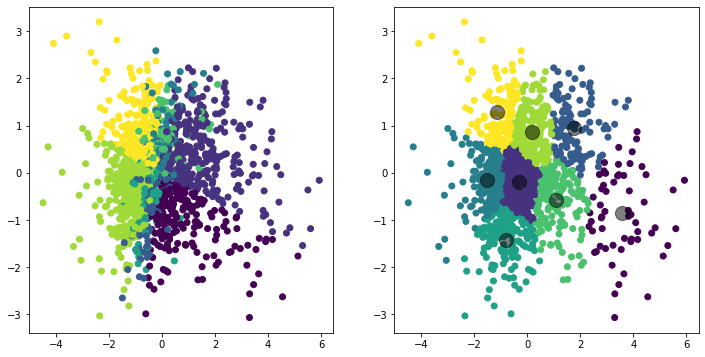

In [62]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

clusters = len(set(targets))

kmeans = KMeans(n_clusters=clusters)
kmeans.fit(X_2)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

fig = plt.figure(0, figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(X_2[:, 0], X_2[:, 1], c=targets)
ax2.scatter(X_2[:, 0], X_2[:, 1], c=labels)
ax2.scatter(centers[:, 0], centers[:, 1], c='k', s=200, alpha=0.5)

plt.show()

In [63]:
from minisom import MiniSom

som = MiniSom(7, 7, 3, sigma=4, learning_rate=0.1)

print("Training...")
som.train_random(X, 20000, verbose=True)  # random training
print("\n...ready!")

Training...


 [  1669 / 20000 ]   8% - 0:00:04 left 

 [  2552 / 20000 ]  13% - 0:00:04 left 

 [  3136 / 20000 ]  16% - 0:00:04 left 

 [  3772 / 20000 ]  19% - 0:00:04 left 

 [  4677 / 20000 ]  23% - 0:00:04 left 

 [  5483 / 20000 ]  27% - 0:00:03 left 

 [  6258 / 20000 ]  31% - 0:00:03 left 

 [  7084 / 20000 ]  35% - 0:00:03 left 

 [  8009 / 20000 ]  40% - 0:00:03 left 

 [  8980 / 20000 ]  45% - 0:00:02 left 

 [  9906 / 20000 ]  50% - 0:00:02 left 

 [ 10792 / 20000 ]  54% - 0:00:02 left 

 [ 11582 / 20000 ]  58% - 0:00:02 left 

 [ 12174 / 20000 ]  61% - 0:00:01 left 

 [ 12881 / 20000 ]  64% - 0:00:01 left 

 [ 13841 / 20000 ]  69% - 0:00:01 left 

 [ 14547 / 20000 ]  73% - 0:00:01 left 

 [ 15197 / 20000 ]  76% - 0:00:01 left 

 [ 16193 / 20000 ]  81% - 0:00:00 left 

 [ 17008 / 20000 ]  85% - 0:00:00 left 

 [ 17581 / 20000 ]  88% - 0:00:00 left 

 [ 18553 / 20000 ]  93% - 0:00:00 left 

 [ 19516 / 20000 ]  98% - 0:00:00 left 

 [ 20000 / 20000 ] 100% - 0:00:00 left 
 quantization error: 0.793463419317882
 topographic error: 0.6155572176514585

...ready!


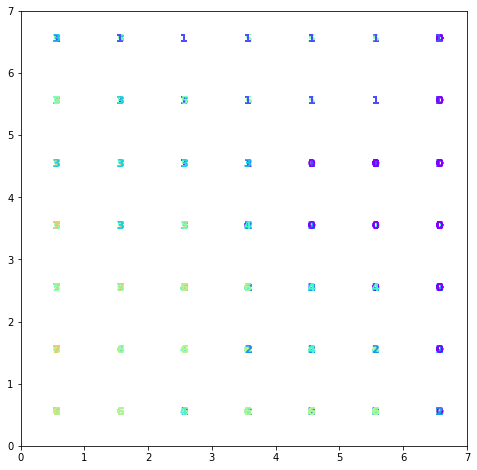

In [64]:
plt.figure(figsize=(8, 8))
for x, t in zip(X, targets):
    w = som.winner(x)
    plt.text(w[0]+.5,  w[1]+.5, str(t),
              color=plt.cm.rainbow(t / 10.), fontdict={'weight': 'bold',  'size': 11})
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.show()